In [ ]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from operator import itemgetter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing

from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler, OneHotEncoder, LabelBinarizer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, KFold, cross_val_predict, StratifiedKFold, train_test_split, learning_curve, ShuffleSplit
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm




In [ ]:
import pandas as pd
import scipy
from scipy import stats

X_train = pd.read_csv("X_train.csv", index_col=[0], header=[0, 1, 2])
X_train=X_train.dropna()

y_train = pd.read_csv("Y_train2.csv", index_col=[0])

X_valid = pd.read_csv("X_valid.csv", index_col=[0], header=[0, 1, 2])
X_valid=X_valid.dropna()

y_valid = pd.read_csv("Y_valid2.csv", index_col=[0])

X_test = pd.read_csv("X_test.csv", index_col=[0], header=[0, 1, 2])
X_test=X_test.dropna()

## input all the X_variables into CatBoostRegressor to assess the model's RMSE

In [ ]:
from catboost import Pool, CatBoostRegressor, cv
from sklearn.metrics import mean_squared_error
import numpy as np
from time import time


cbr = CatBoostRegressor(random_state=42,loss_function='RMSE',eval_metric='RMSE',use_best_model=True)
ttrain = time()

cbr.fit(X_train,y_train, eval_set=(X_valid, y_valid), verbose=0, plot=True)
train_time = time() - ttrain
print(f"train time: {train_time:.10}s")

ttest = time()
pred = cbr.predict(X_valid)
rmse = (np.sqrt(mean_squared_error(y_valid, pred)))

test_time = time() - ttest
print(f"test time:  {test_time:.10}s")
print("RMSE: {:.2f}",rmse)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

train time: 630.3784785s
test time:  0.1533195972s
RMSE: {:.2f} 1.7296830158147116


## Given the low RMSE value and fast processing speed of catboost regressor, the below will use the function of feature importances by catboost regressor to filter the important X_variables

## The criteria of the filtration is the elimination of variables whose value of feature inportance are below 0.

In [ ]:
filtered_X_train=X_train.iloc[:,pd.DataFrame(cbr.get_feature_importance())[pd.DataFrame(cbr.get_feature_importance())[0]>0.1].index]
filtered_X_valid=X_valid.iloc[:,pd.DataFrame(cbr.get_feature_importance())[pd.DataFrame(cbr.get_feature_importance())[0]>0.1].index]
filtered_X_test=X_test.iloc[:,pd.DataFrame(cbr.get_feature_importance())[pd.DataFrame(cbr.get_feature_importance())[0]>0.1].index]

## After choosing the important features, less X_variables requires to input into other models. Therefore, the speed of the remaining model comparison can be boosted up.

In [ ]:
from time import time

def comparison(model, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(model)
    t0 = time()
    model.fit(filtered_X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    prediction = model.predict(filtered_X_valid)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    rmse = (np.sqrt(mean_squared_error(y_valid, prediction)))
    print("RMSE: {:.2f}".format(rmse))

    print()

    if custom_name:
        model_descr = str(custom_name)
    else:
        model_descr = model.__class__.__name__
    return model_descr, rmse



results = []
for model, name in (
    (xgb.XGBRegressor(),"XGBRegressor"),
    (CatBoostRegressor(random_state=42,loss_function='RMSE'),'CatBoostRegressor'),
    (ExtraTreesRegressor(),"ExtraTreesRegressor"),
    (RandomForestRegressor(),"RandomForestRegressor"),
    (KNeighborsRegressor(),'KNeighborsRegressor'),
    (Ridge(),"Ridge"),
    (BaggingRegressor(),"BaggingRegressor"),
    (BayesianRidge(),'BayesianRidge'),
    (ElasticNet(),'ElasticNet'),
    (Lasso(),'Lasso'),
    (GradientBoostingRegressor(),'GradientBoostingRegressor'),
    (SGDRegressor(),"SGDRegressor")
):

    print("=" * 80)
    print(name)
    results.append(comparison(model, name))

XGBRegressor
________________________________________________________________________________
Training: 
XGBRegressor()
[03:48:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train time: 7.05s
test time:  0.0123s
RMSE: 1.74

CatBoostRegressor
________________________________________________________________________________
Training: 
Learning rate set to 0.063917
0:	learn: 1.9576516	total: 45.6ms	remaining: 45.5s
1:	learn: 1.9404708	total: 81.8ms	remaining: 40.8s
2:	learn: 1.9248917	total: 115ms	remaining: 38.3s
3:	learn: 1.9099471	total: 152ms	remaining: 37.9s
4:	learn: 1.8967102	total: 188ms	remaining: 37.5s
5:	learn: 1.8842188	total: 224ms	remaining: 37.1s
6:	learn: 1.8728839	total: 265ms	remaining: 37.6s
7:	learn: 1.8630879	total: 310ms	remaining: 38.5s
8:	learn: 1.8539791	total: 347ms	remaining: 38.3s
9:	learn: 1.8451127	total: 385ms	remaining: 38.1s
10:	learn: 1.8382264	total: 422ms	remaining: 37.9s
11:	learn:

## Based on the above result, there are 5 regressors (XGB regressor, catboost regressor, extra tree regressor, random forest regressor, gradient boosting regressor) in total whiose RMSE value are between 1.74 to 1.76.


##Although the RMSE value of Random forest regressor is 1.75, it costs very lengthy of training time and 3 regressors have lower RMSE value than it based on the above result. Therefore, it will be eliminated to speed up the process. of best model selection  




In [ ]:
from time import time

def comparison(model, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(model)
    t0 = time()
    model.fit(filtered_X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:}s")

    t0 = time()
    prediction = model.predict(filtered_X_valid)
    test_time = time() - t0
    print(f"test time:  {test_time:}s")

    cross_rmse = np.sqrt(-cross_val_score(model, filtered_X_valid, y_valid, scoring="neg_mean_squared_error", cv=5))
    mean_of_cross_rmse=cross_rmse.mean()
    print("Mean squared error for cross validation=  ",mean_of_cross_rmse)

    rmse = (np.sqrt(mean_squared_error(y_valid, prediction)))
    print("RMSE:",rmse)
    avg_rmse=(mean_of_cross_rmse+rmse)/2
    print("average between Mean squared error for cross validation and RMSE",avg_rmse)
    print()

    if custom_name:
        model_descr = str(custom_name)
    else:
        model_descr = model.__class__.__name__
    return model_descr, mean_of_cross_rmse, rmse



results = []
for model, name in (
    (CatBoostRegressor(loss_function='RMSE',verbose=0,eval_metric='RMSE'),'CatBoostRegressor'),
    (xgb.XGBRegressor(),"XGBRegressor"),
    (ExtraTreesRegressor(),"ExtraTreesRegressor"),
    (GradientBoostingRegressor(),'GradientBoostingRegressor'),
):

    print("=" * 80)
    print(name)
    results.append(comparison(model, name))




CatBoostRegressor
________________________________________________________________________________
Training: 
train time: 52.082757234573364s
test time:  0.013726234436035156s
Mean squared error for cross validation=   1.8099072312074118
RMSE: 1.7308065824494308
average between Mean squared error for cross validation and RMSE 1.7703569068284213

XGBRegressor
________________________________________________________________________________
Training: 
XGBRegressor()
[12:09:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
train time: 8.293984413146973s
test time:  0.02015233039855957s
[12:09:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:09:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now d

## Based on the above results, the CatBoostRegressor gains the highest score in comparision with the other 3 regression models, so the other 3 model regressors will be eliminated. For the following step, hyperparameters optimization will only focus on the catBoost regression model due to lengthy of time to optimize all the models' hyperparameters.  

In [ ]:
new_cbr = CatBoostRegressor(random_state=42,loss_function='RMSE',eval_metric='RMSE',use_best_model=True, depth=6,l2_leaf_reg=3,iterations=200,learning_rate=0.1)
ttrain = time()

new_cbr.fit(filtered_X_train,y_train, eval_set=(filtered_X_valid, y_valid), verbose=0, plot=True)
train_time = time() - ttrain
print(f"train time: {train_time:.10}s")

ttest = time()
pred = new_cbr.predict(filtered_X_valid)
rmse = (np.sqrt(mean_squared_error(y_valid, pred)))

test_time = time() - ttest
print(f"test time:  {test_time:.10}s")
print("RMSE:",rmse)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

train time: 5.97188735s
test time:  0.008969545364s
RMSE: 1.7341680627337894


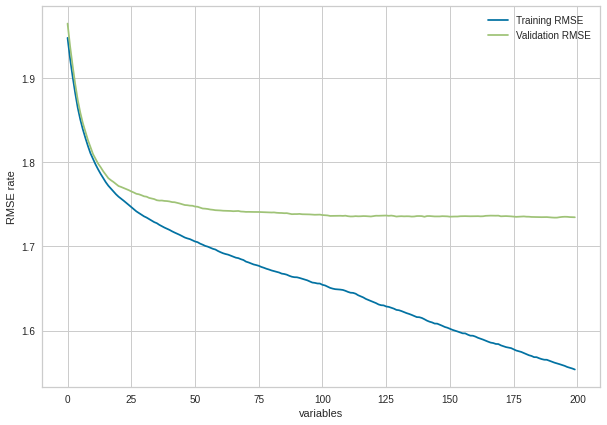

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(new_cbr.evals_result_["learn"]["RMSE"], label="Training RMSE")
plt.plot(new_cbr.evals_result_["validation"]["RMSE"], label="Validation RMSE")
plt.xlabel("variables")
plt.ylabel("RMSE rate")
plt.legend()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

train time: 10.98407078s
test time:  0.01548886299s
RMSE: 1.7931058129475912


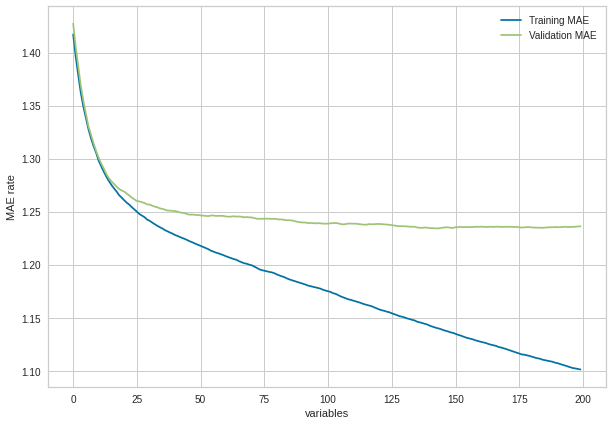

In [ ]:
other_new_cbr = CatBoostRegressor(random_state=42,loss_function='MAE',eval_metric='MAE',use_best_model=True, depth=6,l2_leaf_reg=3,iterations=200,learning_rate=0.1)
ttrain = time()


other_new_cbr.fit(filtered_X_train,y_train, eval_set=(filtered_X_valid, y_valid), verbose=0, plot=True)
train_time = time() - ttrain
print(f"train time: {train_time:.10}s")

ttest = time()
pred = other_new_cbr.predict(filtered_X_valid)
rmse = (np.sqrt(mean_squared_error(y_valid, pred)))

test_time = time() - ttest
print(f"test time:  {test_time:.10}s")
print("RMSE:",rmse)


plt.figure(figsize=(10,7))
plt.plot(other_new_cbr.evals_result_["learn"]["MAE"], label="Training MAE")
plt.plot(other_new_cbr.evals_result_["validation"]["MAE"], label="Validation MAE")
plt.xlabel("variables")
plt.ylabel("MAE rate")
plt.legend()



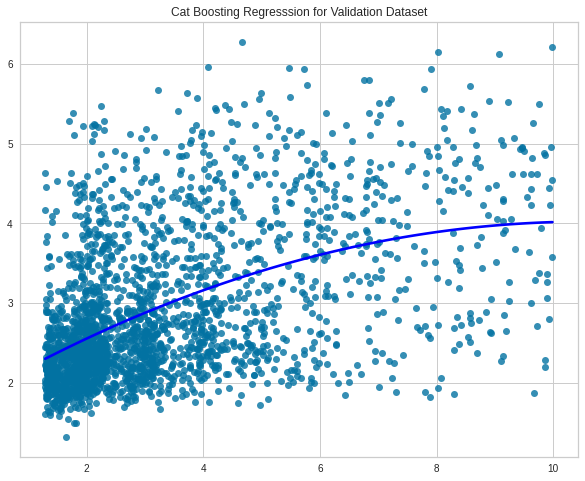

In [ ]:
import seaborn as sns

pred = other_new_cbr.predict(filtered_X_valid)
xChart = [np.array(y_valid)]
yChart = [np.array(pred)]

plt.figure(figsize=(10,8))
sns.regplot(x=xChart, y=yChart,
            ci=None, line_kws={"color": "blue"},order=2)
plt.title("Cat Boosting Regresssion for Validation Dataset")
plt.show()